### What is ARIMA:
ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. ARIMA models have three parameters like ARIMA(p, d, q).  

1. **p** is the number of lagged values that need to be added or subtracted from the values (label column). It captures the autoregressive part of ARIMA.
2. **d** represents the number of times the data needs to differentiate to produce a stationary signal. If it’s stationary data, the value of d should be 0, and if it’s seasonal data, the value of d should be 1. d captures the integrated part of ARIMA.
3. **q** is the number of lagged values for the error term added or subtracted from the values (label column). It captures the moving average part of ARIMA.

In [35]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

In [3]:
today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = today - timedelta(days=365)
start_date = d2

print("Start Date", start_date, "End Date", end_date)

Start Date 2023-12-26 End Date 2024-12-25


In [4]:
# Collecting Google Stock Price using Yahoo Finance API
dataset = yf.download('GOOG',
                      start=start_date,
                      end=end_date, 
                      progress=False)

In [5]:
dataset.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2023-12-26,142.308670,142.820007,143.945007,142.500000,142.979996,11170100
2023-12-27,140.933624,141.440002,143.320007,141.050995,142.830002,17288400
2023-12-28,140.774185,141.279999,142.270004,140.828003,141.850006,12192500
2023-12-29,140.425430,140.929993,141.434998,139.899994,140.679993,14872700
2024-01-02,139.060349,139.559998,140.615005,137.740005,139.600006,20071900


In [6]:
dataset['Date'] = dataset.index
dataset = dataset[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
dataset.reset_index(drop=True, inplace=True)

In [7]:
print(dataset.head())

Price        Date        Open        High         Low       Close   Adj Close  \
Ticker                   GOOG        GOOG        GOOG        GOOG        GOOG   
0      2023-12-26  142.979996  143.945007  142.500000  142.820007  142.308670   
1      2023-12-27  142.830002  143.320007  141.050995  141.440002  140.933624   
2      2023-12-28  141.850006  142.270004  140.828003  141.279999  140.774185   
3      2023-12-29  140.679993  141.434998  139.899994  140.929993  140.425430   
4      2024-01-02  139.600006  140.615005  137.740005  139.559998  139.060349   

Price     Volume  
Ticker      GOOG  
0       11170100  
1       17288400  
2       12192500  
3       14872700  
4       20071900  


In [8]:
dataset = dataset[['Date', 'Close']]
print(dataset.head())

Price        Date       Close
Ticker                   GOOG
0      2023-12-26  142.820007
1      2023-12-27  141.440002
2      2023-12-28  141.279999
3      2023-12-29  140.929993
4      2024-01-02  139.559998


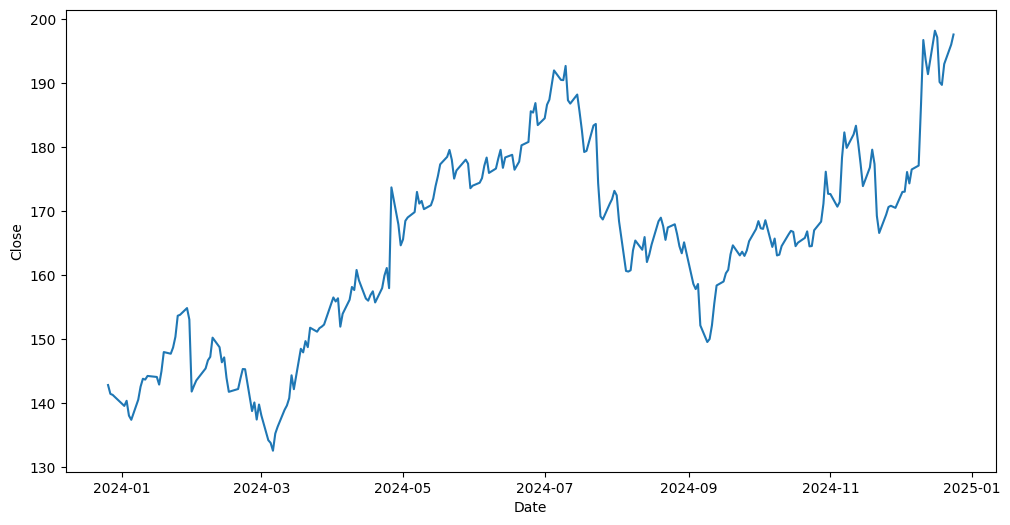

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(dataset["Date"], dataset["Close"])
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

> The data visualization graph about the closing stock prices above shows that our dataset is not stationary. Trends and changing levels in the graph rules out the dataset as a stationary one!

To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataset['Close'], model='multiplicative', period=30)

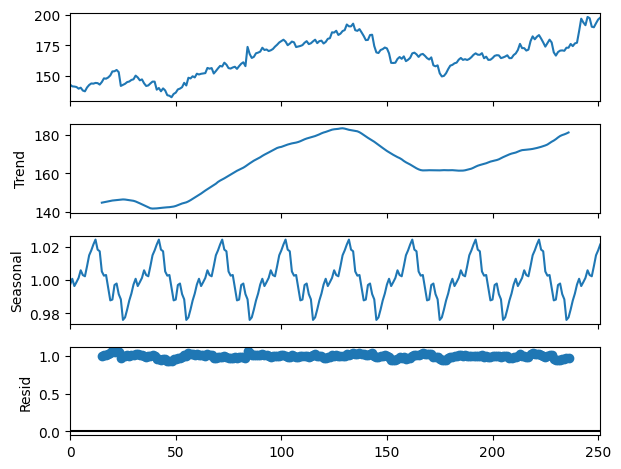

In [11]:
# Plot the decomposed components
result.plot()
plt.show()

> The dataset is not stationary, it is seasonal! We need to use the Seasonal ARIMA **(SARIMA)** model for Time Series Forecasting on this data. 

### The values of p, d, q
To use ARIMA or SARIMA, we need to find the p, d, and q values.  
We can find the value of $p$ by plotting the autocorrelation of the Close column and the value of $q$ by plotting the partial autocorrelation plot.  
The value of $d$ is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the $d$ value.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

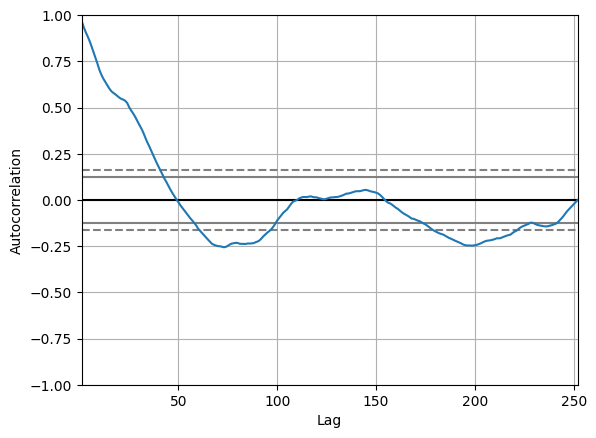

In [12]:
pd.plotting.autocorrelation_plot(dataset["Close"])

> In the above autocorrelation plot, the curve is moving down after the 8th line of the first boundary. That is how to decide the p-value. Hence the value of $p$ is 8.

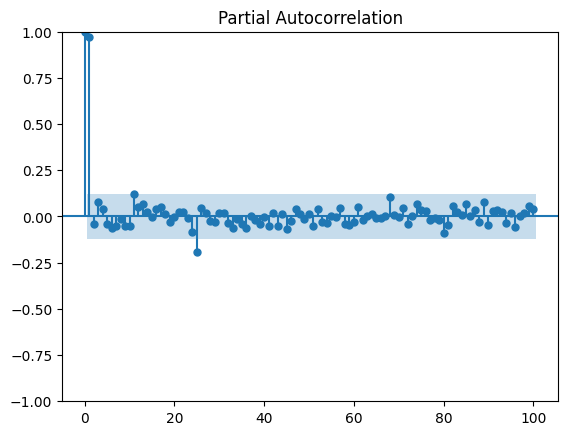

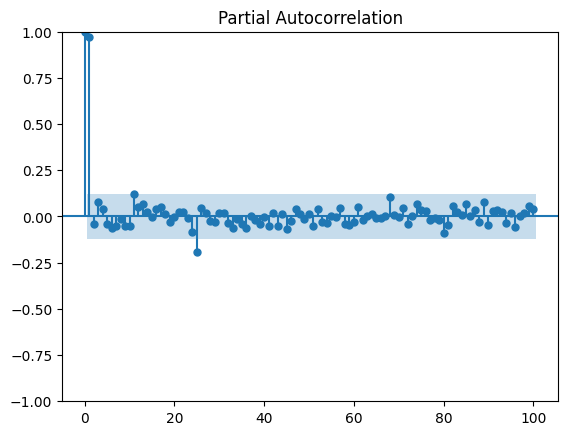

In [14]:
# For finding the value of 'q'
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(dataset["Close"], lags = 100)

> In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the $q$ value. Hence the value of $q$ is 2.

#### Building ARIMA model
Even though the dataset is **not** stationary!

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
p, d, q = 5, 1, 2
arima_model = ARIMA(dataset['Close'], order=(p, d, q))
fitted_model = arima_model.fit()

In [31]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   GOOG   No. Observations:                  252
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -620.344
Date:                Wed, 25 Dec 2024   AIC                           1256.687
Time:                        08:32:22   BIC                           1284.891
Sample:                             0   HQIC                          1268.037
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1620      0.638     -0.254      0.800      -1.413       1.089
ar.L2          0.5231      0.623      0.839      0.401      -0.698       1.745
ar.L3         -0.0924      0.089     -1.039      0.2

In [32]:
# Predicting with ARIMA model
arima_predictions = fitted_model.predict()

In [33]:
print(arima_predictions)

0        0.000000
1      142.820068
2      141.370088
3      141.428917
4      140.987530
          ...    
247    196.783315
248    189.916597
249    190.645250
250    193.948584
251    195.622493
Name: predicted_mean, Length: 252, dtype: float64


> The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data.

#### Building SARIMA model

In [36]:
sarima_model = sm.tsa.statespace.SARIMAX(dataset['Close'],
                                         order=(p, d, q),
                                         seasonal_order=(p, d, q, 12))

In [ ]:
sarima_fit = sarima_model.fit()

In [38]:
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               GOOG   No. Observations:                  252
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -601.394
Date:                            Wed, 25 Dec 2024   AIC                           1232.788
Time:                                    08:43:45   BIC                           1284.935
Sample:                                         0   HQIC                          1253.802
                                            - 252                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0267      1.305     -0.020      0.984      -2.585       2.531
ar.L2          0.5619      1.263   

In [39]:
# Predicting Future Stock Prices
sarima_predictions = sarima_fit.predict(len(dataset), len(dataset) + 10)

In [40]:
print(sarima_predictions)

252    196.158180
253    193.019477
254    193.107366
255    194.203550
256    194.743921
257    195.186186
258    195.507047
259    194.749579
260    193.172711
261    193.653776
262    194.435335
Name: predicted_mean, dtype: float64


<Axes: >

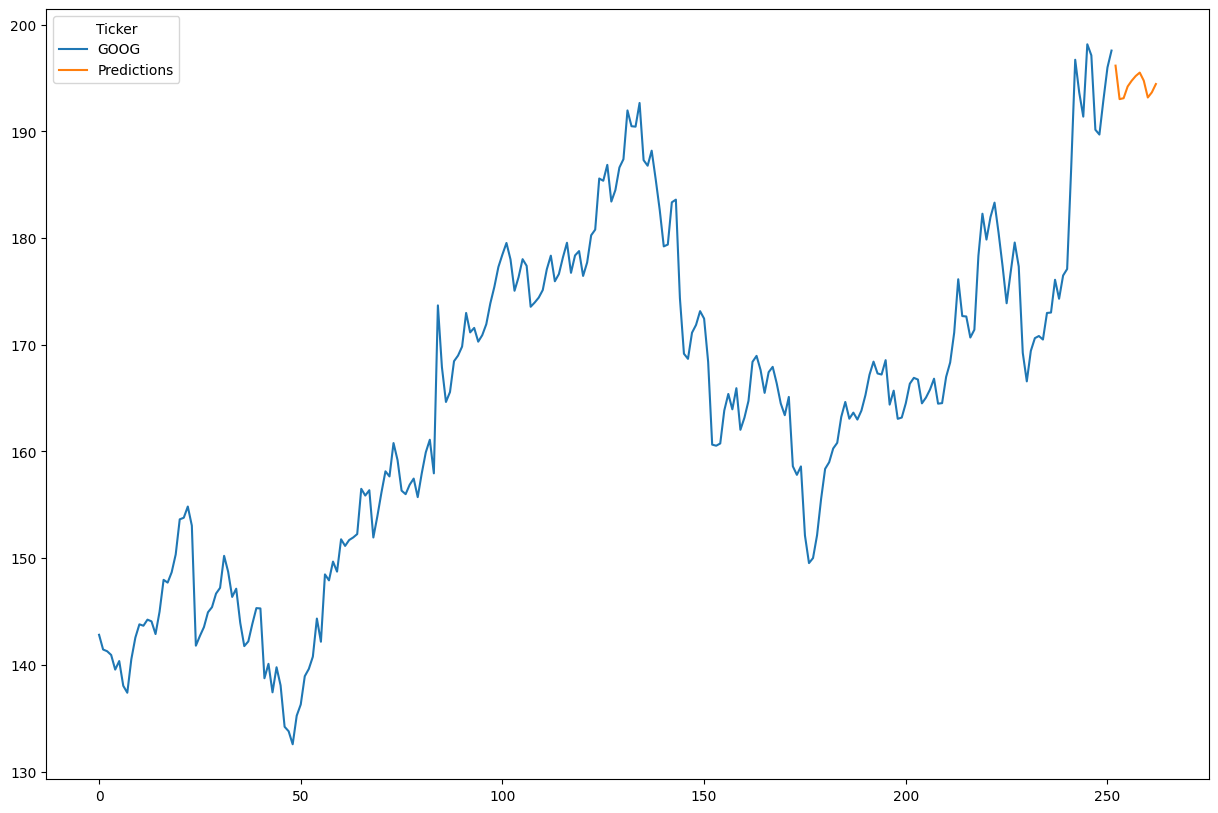

In [41]:
# Plotting the Predictions
dataset['Close'].plot(legend=True, label="Training Data", figsize=(15, 10))
sarima_predictions.plot(legend=True, label="Predictions")